In [1]:
import pandas as pd
import os
import re
import glob
import json
import matplotlib.pyplot as plt 
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.sparse import save_npz, load_npz
import numpy as np
import nltk
import gzip
from scipy.spatial.distance import cosine
from scipy.sparse import hstack, vstack
from utils import Word2vecProcessor
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from feature_extraction import hand_features, gen_or_load_feats, word_overlap_features, cosine_features
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

from plot_utils import plot_confusion_matrix
from eda.writingdirs import to_dirs

%matplotlib inline

In [2]:
import ipywidgets as widgets
from ipywidgets import interact

In [3]:
import sys

my_utils_path = '/home/kim/spam-detector/src/utils'
if my_utils_path not in sys.path:
    sys.path.append(my_utils_path)

from text_preprocessing import Preprocessor
from plot_tools import plot_cm

### Merge separate files into one json

In [26]:
result = []
for f in tqdm_notebook(glob.glob("../data/labeling/Dni.ru/bait/*.json")):
    print("Processing {0} ...".format(f))
    with open(f, "r+", encoding="utf-8") as infile:
        fstr = infile.readlines() # !!!!!
        result.append(fstr)
        
with open("../data/labeling/bait_merged.json", "w") as outfile:
    json.dump(result, outfile, ensure_ascii=False)

Processing ../data/labeling/Dni.ru/bait/13231.json ...
Processing ../data/labeling/Dni.ru/bait/24606.json ...
Processing ../data/labeling/Dni.ru/bait/12234.json ...
Processing ../data/labeling/Dni.ru/bait/10578.json ...
Processing ../data/labeling/Dni.ru/bait/12225.json ...
Processing ../data/labeling/Dni.ru/bait/17749.json ...
Processing ../data/labeling/Dni.ru/bait/25688.json ...
Processing ../data/labeling/Dni.ru/bait/37874.json ...
Processing ../data/labeling/Dni.ru/bait/30958.json ...
Processing ../data/labeling/Dni.ru/bait/1269.json ...
Processing ../data/labeling/Dni.ru/bait/19669.json ...
Processing ../data/labeling/Dni.ru/bait/14533.json ...
Processing ../data/labeling/Dni.ru/bait/35757.json ...
Processing ../data/labeling/Dni.ru/bait/42296.json ...
Processing ../data/labeling/Dni.ru/bait/12374.json ...
Processing ../data/labeling/Dni.ru/bait/4366.json ...
Processing ../data/labeling/Dni.ru/bait/14569.json ...
Processing ../data/labeling/Dni.ru/bait/2796.json ...
Processing ..

Processing ../data/labeling/Dni.ru/bait/26847.json ...
Processing ../data/labeling/Dni.ru/bait/11439.json ...
Processing ../data/labeling/Dni.ru/bait/23986.json ...
Processing ../data/labeling/Dni.ru/bait/43675.json ...
Processing ../data/labeling/Dni.ru/bait/43795.json ...
Processing ../data/labeling/Dni.ru/bait/14824.json ...
Processing ../data/labeling/Dni.ru/bait/12260.json ...
Processing ../data/labeling/Dni.ru/bait/31605.json ...
Processing ../data/labeling/Dni.ru/bait/31957.json ...
Processing ../data/labeling/Dni.ru/bait/2079.json ...
Processing ../data/labeling/Dni.ru/bait/12413.json ...
Processing ../data/labeling/Dni.ru/bait/41746.json ...
Processing ../data/labeling/Dni.ru/bait/33547.json ...
Processing ../data/labeling/Dni.ru/bait/24333.json ...
Processing ../data/labeling/Dni.ru/bait/206.json ...
Processing ../data/labeling/Dni.ru/bait/43178.json ...
Processing ../data/labeling/Dni.ru/bait/41916.json ...
Processing ../data/labeling/Dni.ru/bait/14748.json ...
Processing ..

In [60]:
bait = pd.read_json("../data/labeling/bait_merged.json", encoding='utf-8', orient='records', typ='frame')

In [61]:
bait.columns = ["id", "title", "text", "url"]

tqdm_notebook.pandas(desc="replace_commas")
bait["url"] = bait.url.progress_apply(lambda x : x.replace("\"", "").replace("\\", ""))

In [62]:
bait.head()

,id,title,text,url
0,96621564,"""Покинувшая Россию Нюша сделала важное заявлен...","""Популярная исполнительница Нюша приняла серье...",http://www.dni.ru/showbiz/2018/7/10/402084.html
1,84943597,"""Охмурил аферой\"": отравленного Скрипаля испол...","""Великобритания охмурила Европу аферой с отрав...",http://www.dni.ru/society/2018/5/29/398984.html
2,102144812,"""Повзрослевший сын Королевой затмил голого Тар...","""Сын Наташи Королевой и Сергея Глушко поразил ...",http://www.dni.ru/showbiz/2018/7/31/403754.html
3,52233679,"""Россия встала на защиту развратных курсантов ...","""Скандал с непристойным роликом, записанным ул...",http://www.dni.ru/regions/2018/1/17/389237.html
4,102837602,"""Хочет стать богатой вдовой\"": сексолог о замы...","""Сексолог и профессор Московского института пс...",http://www.dni.ru/showbiz/2018/8/3/404004.html


### Upload articles from news agencies

In [51]:
agencies = pd.read_json("../data/raw/cleaned/newsdump18.json", encoding='utf-8', lines=True, typ='frame')
agencies = agencies[(agencies["source"]=="Interfax") | (agencies["source"]=="RIA") | (agencies["source"]=="TASS")]
agencies = agencies[["doc_id", "title", "text", "url"]]

In [52]:
agencies.shape[0]

337351

In [55]:
agencies.head()

,doc_id,title,text,url
0,124272138,Россия поставила Анголе четыре истребителя Су-...,Россия поставила Анголе четыре истреьителя Су-...,http://www.interfax.ru/world/638657
1,124272120,Нерезиденты в октябре купили ОФЗ на аукционах ...,Нерезиденты и дочерние иностранные банки в окт...,http://www.interfax.ru/business/638658
2,111233217,Житель Ростовской области осужден на 11 лет за...,Северо-Кавказский окружной военный суд вынес о...,http://www.interfax.ru/russia/627809
3,110816371,"Динамо"" обыграло ""Оренбург"" в матче чемпионата...","Футболисты московского ""Динамо"" нанесли пораже...",http://www.interfax.ru/sport/627601
4,121896641,Активистки FEMEN провели в Париже акцию против...,Движение FEMEN взяло на себя ответственность з...,http://www.interfax.ru/world/637359


In [65]:
agencies_sample = agencies.sample(n=10000)

In [68]:
agencies_sample.tail()

,doc_id,title,text,url
512363,98805913,В митинге против пенсионных изменений в Москве...,"МОСКВА, 18 июля. /ТАСС/. Около 1,5 тыс. челове...",http://tass.ru/obschestvo/5385843
438741,117195039,Полиция составила протокол на участницу съемок...,"МОСКВА, 12 окт — РИА Новости. Сотрудники полиц...",https://ria.ru/incidents/20181012/1530511948.html
148701,79201386,"ЦБ РФ 3 мая приобрел для Минфина валюту на 18,...",ЦБ РФ 3 мая приобрел на рынке для Минфина валю...,http://www.interfax.ru/business/611562
113228,75196750,Медведев распорядился выдвинуть кандидатов в с...,"МОСКВА, 17 апреля. /ТАСС/. Премьер-министр РФ ...",http://tass.ru/ekonomika/5135513
399327,103320051,Трамп сыграл в гольф с одним из инициаторов но...,"ВАШИНГТОН, 6 авг — РИА Новости. Президент США ...",https://ria.ru/world/20180806/1525982280.html


In [70]:
agencies_sample.to_json("../data/raw/agencies-sample.json", force_ascii=False, lines=True, orient='records')

### Artificial Data

In [114]:
titles = agencies_sample.head(1000).title.values

In [115]:
texts = agencies_sample.tail(1000).text.values

In [116]:
urls = agencies_sample.tail(1000).url.values

In [124]:
doc_id = (np.ones(shape=(1000,), dtype=int)*-1).tolist()

In [125]:
artificial = pd.DataFrame({"doc_id" : doc_id, "title" : titles, "text" : texts, "url" : urls})

In [126]:
artificial

,doc_id,title,text,url
0,-1,Власти Саратова выделили по миллиону семьям по...,"МОСКВА, 12 фев — РИА Новости. Музыкальная прог...",https://ria.ru/culture/20180212/1514463436.html
1,-1,В Москве и Санкт-Петербурге стартовал междунар...,"МОСКВА, 13 фев — РИА Новости. Договор о сотруд...",https://ria.ru/culture/20180213/1514545495.html
2,-1,Глобальное потепление работает на Россию и стр...,"СИМФЕРОПОЛЬ, 12 фев — РИА Новости. Главным нап...",https://ria.ru/incidents/20180212/1514471790.html
3,-1,АСВ оценило объем выплат вкладчикам ОФК банка ...,"МОСКВА, 21 июня. /ТАСС/. В четырех московских ...",http://tass.ru/moskva/5310413
4,-1,Роскомнадзор пообещал блокировать способствующ...,"В Вашингтоне исходят из того, что Москва также...",http://tass.ru/n/5092504
5,-1,Глава минобороны США подтвердил приверженность...,"МАХАЧКАЛА, 25 фев — РИА Новости. Начальник отд...",https://ria.ru/incidents/20180225/1515246051.html
6,-1,Спасатели в течение шести часов начнут поиски ...,"БЕРЛИН, 12 ноя — РИА Новости. Российско-герман...",https://ria.ru/politics/20181112/1532641226.html
7,-1,Тренер: фигурист Алиев будет готовиться к прои...,Большое внимание участники также уделили вопро...,http://tass.ru/novosti-partnerov/5415796
8,-1,Профицит бюджета РФ в январе-октябре составил ...,Глава отдела МВД России по Первоуральску (Свер...,http://www.interfax.ru/russia/637007
9,-1,Росгосцирк обжалует решение суда о закрытии Ек...,"БЕРЛИН, 23 фев – РИА Новости. Представитель МИ...",https://ria.ru/syria/20180223/1515192856.html


In [127]:
artificial["label"] = artificial["text"].apply(lambda x : "Unrelated")

bait["label"] = bait["text"].apply(lambda x : "Clickbait")

agencies_sample["label"] = agencies_sample["text"].apply(lambda x : "Journalism")

In [130]:
agencies_sample.to_json("../data/raw/agencies-sample.json", force_ascii=False, lines=True, orient='records')
artificial.to_json("../data/raw/artificial.json", force_ascii=False, lines=True, orient='records')
bait.to_json("../data/raw/bait.json", force_ascii=False, lines=True, orient='records')

### Preprocessing

In [2]:
with gzip.open("../data/external/news_upos_cbow_300_2_2017.bin.gz") as model_file:
    word2vec = Word2vecProcessor(model_file)

In [3]:
with open("../data/external/stopwords.txt", mode='r') as stop_file:
    stopwords = stop_file.readlines()
    word2vec.set_stopwords(stopwords)

In [136]:
word2vec.beautify(agencies_sample.loc[0].title)

'россия поставлять ангола четыре истребитель'

In [139]:
tqdm_notebook.pandas(desc="normalization")
agencies_sample["text_norm"] = agencies_sample.text.progress_apply(word2vec.beautify)

In [140]:
tqdm_notebook.pandas(desc="normalization")
agencies_sample["title_norm"] = agencies_sample.title.progress_apply(word2vec.beautify)

In [141]:
tqdm_notebook.pandas(desc="normalization")
bait["text_norm"] = bait.text.progress_apply(word2vec.beautify)

In [142]:
tqdm_notebook.pandas(desc="normalization")
bait["title_norm"] = bait.title.progress_apply(word2vec.beautify)

In [143]:
tqdm_notebook.pandas(desc="normalization")
artificial["text_norm"] = artificial.text.progress_apply(word2vec.beautify)

In [144]:
tqdm_notebook.pandas(desc="normalization")
artificial["title_norm"] = artificial.title.progress_apply(word2vec.beautify)

In [150]:
agencies_sample[["doc_id", "title_norm", 
                 "text_norm", "url", "label"]].to_json("../data/interim/agencies-sample.json", force_ascii=False, 
                                                       lines=True, orient='records')

artificial[["doc_id", "title_norm", 
            "text_norm", "url", "label"]].to_json("../data/interim/artificial.json", force_ascii=False, 
                                                  lines=True, orient='records')

bait[["id", "title_norm", 
      "text_norm", "url", "label"]].to_json("../data/interim/bait.json", force_ascii=False, lines=True, o
                                            rient='records')

### TF-IDF

In [180]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=20000, min_df=1e-4)

In [181]:
corpora = []

corpora.extend(agencies_sample.text_norm.values.flatten())
corpora.extend(agencies_sample.title_norm.values.flatten())
corpora.extend(bait.text_norm.values.flatten())
corpora.extend(bait.title_norm.values.flatten())

# we don't need artificial df texts & titles, as they're already presented in agencies_sample

In [182]:
tfidf.fit(corpora)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=0.0001,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [183]:
#agencies
agencies_titles_tfidf = tfidf.transform(agencies_sample.title_norm.values.flatten())
agencies_texts_tfidf = tfidf.transform(agencies_sample.text_norm.values.flatten())

#bait
bait_titles_tfidf = tfidf.transform(bait.title_norm.values.flatten())
bait_texts_tfidf = tfidf.transform(bait.text_norm.values.flatten())

#artificial entities
art_titles_tfidf = tfidf.transform(artificial.title_norm.values.flatten())
art_texts_tfidf = tfidf.transform(artificial.text_norm.values.flatten())

In [188]:
if not os.path.exists("../data/interim/matrixform"):
    os.mkdir("../data/interim/matrixform")

#agencies
save_npz("../data/interim/matrixform/agencies_titles_tfidf.npz", agencies_titles_tfidf)
save_npz("../data/interim/matrixform/agencies_texts_tfidf.npz", agencies_texts_tfidf)
         
#bait
save_npz("../data/interim/matrixform/bait_titles_tfidf.npz", bait_titles_tfidf)
save_npz("../data/interim/matrixform/bait_texts_tfidf.npz", bait_texts_tfidf)

#artificial entities
save_npz("../data/interim/matrixform/art_titles_tfidf.npz", art_titles_tfidf)
save_npz("../data/interim/matrixform/art_texts_tfidf.npz", art_texts_tfidf)

### Classification

In [3]:
agencies_sample = pd.read_json("../data/raw/agencies-sample.json",lines=True, orient='records')
artificial = pd.read_json("../data/raw/artificial.json", lines=True, orient='records')
bait = pd.read_json("../data/raw/bait.json", lines=True, orient='records')

In [3]:
if not os.path.exists("../data/interim/features"):
    os.mkdir("../data/interim/features")

In [17]:
agencies_overlap = gen_or_load_feats(word_overlap_features, 
                                     agencies_sample.title.tolist(), 
                                     agencies_sample.text.tolist(), 
                                     "../data/interim/features/overlap.agencies.npy")

In [15]:
artificial_overlap = gen_or_load_feats(word_overlap_features, 
                                     artificial.title.tolist(), 
                                     artificial.text.tolist(), 
                                     "../data/interim/features/overlap.artificial.npy")

In [16]:
bait_overlap = gen_or_load_feats(word_overlap_features, 
                                     bait.title.tolist(), 
                                     bait.text.tolist(), 
                                     "../data/interim/features/overlap.bait.npy")

In [18]:
bait_overlap.mean()

0.5185328914766018

In [19]:
artificial_overlap.mean()

0.5798842246608006

In [21]:
agencies_overlap.mean()

0.6364697139004637

/home/kim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


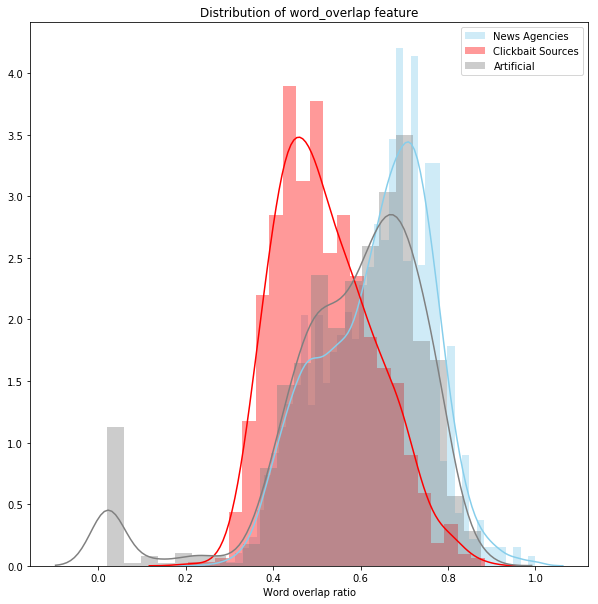

In [22]:
plt.figure(figsize=(10,10))
sns.distplot(agencies_overlap, color="skyblue", label="News Agencies")
sns.distplot(bait_overlap, color="red", label="Clickbait Sources")
sns.distplot(artificial_overlap, color="grey", label="Artificial")
plt.xlabel("Word overlap ratio")
plt.title("Distribution of word_overlap feature")
plt.legend()
plt.show()

In [23]:
agencies_hand = gen_or_load_feats(hand_features, 
                                     agencies_sample.title.tolist(), 
                                     agencies_sample.text.tolist(), 
                                     "../data/interim/features/hand.agencies.npy")

In [24]:
artificial_hand = gen_or_load_feats(hand_features, 
                                    artificial.title.tolist(), 
                                    artificial.text.tolist(), 
                                    "../data/interim/features/hand.artificial.npy")

In [25]:
bait_hand = gen_or_load_feats(hand_features, 
                              bait.title.tolist(), 
                              bait.text.tolist(), 
                              "../data/interim/features/hand.bait.npy")

Cosine features (w2v)

In [4]:
agencies_cos = gen_or_load_feats(cosine_features, 
                                 agencies_sample.title.tolist(), 
                                 agencies_sample.text.tolist(), 
                                 "../data/interim/features/cosine.agencies.npy")

4059it [01:31, 35.15it/s]/home/kim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kim/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
10000it [03:41, 45.21it/s]


In [5]:
artificial_cos = gen_or_load_feats(cosine_features, 
                                   artificial.title.tolist(), 
                                   artificial.text.tolist(), 
                                   "../data/interim/features/cosine.artificial.npy")

1000it [00:22, 44.83it/s]


In [6]:
bait_cos = gen_or_load_feats(cosine_features, 
                             bait.title.tolist(), 
                             bait.text.tolist(), 
                             "../data/interim/features/cosine.bait.npy")

1048it [00:28, 36.79it/s]


In [9]:
agencies_cos = np.nan_to_num(agencies_cos)

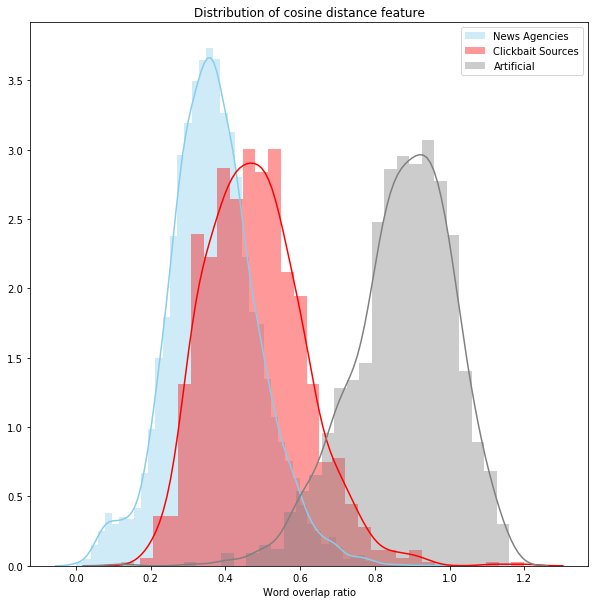

In [12]:
plt.figure(figsize=(10,10))
sns.distplot(agencies_cos, color="skyblue", label="News Agencies")
sns.distplot(bait_cos, color="red", label="Clickbait Sources")
sns.distplot(artificial_cos, color="grey", label="Artificial")
plt.xlabel("Word overlap ratio")
plt.title("Distribution of cosine distance feature")
plt.legend()
plt.show()

### Stack feature matrices

In [195]:
#agencies
agencies_titles_tfidf = load_npz("../data/interim/matrixform/agencies_titles_tfidf.npz")
agencies_texts_tfidf = load_npz("../data/interim/matrixform/agencies_texts_tfidf.npz")
agencies_features = hstack((agencies_texts_tfidf, agencies_titles_tfidf, 
                            np.hstack((agencies_overlap, agencies_hand, agencies_cos.reshape(-1,1)))
                           ))    
#agencies_features = np.hstack((agencies_overlap, agencies_hand, agencies_cos.reshape(-1,1)))   
#save_npz("../data/interim/matrixform/agencies_features.npz", agencies_features)

#bait
bait_titles_tfidf = load_npz("../data/interim/matrixform/bait_titles_tfidf.npz")
bait_texts_tfidf = load_npz("../data/interim/matrixform/bait_texts_tfidf.npz")
bait_features = hstack((bait_texts_tfidf, bait_titles_tfidf, 
                        np.hstack((bait_overlap, bait_hand, bait_cos.reshape(-1,1)))
                       ))   
#bait_features = np.hstack((bait_overlap, bait_hand, bait_cos.reshape(-1,1))) 
#save_npz("../data/interim/matrixform/bait_features.npz", bait_features)

#artificial entities
art_titles_tfidf = load_npz("../data/interim/matrixform/art_titles_tfidf.npz")
art_texts_tfidf = load_npz("../data/interim/matrixform/art_texts_tfidf.npz")
artificial_features = hstack((art_texts_tfidf, art_titles_tfidf, 
                              np.hstack((artificial_overlap, artificial_hand, artificial_cos.reshape(-1,1)))
                             )) 
#artificial_features = np.hstack((artificial_overlap, artificial_hand, artificial_cos.reshape(-1,1)))
#save_npz("../data/interim/matrixform/art_features.npz", artificial_features)

In [202]:
X = vstack((agencies_features, bait_features, artificial_features))

In [197]:
data = pd.concat([agencies_sample, bait.rename(index=str, columns={"id" : "doc_id"}), artificial])

In [198]:
le = LabelEncoder()
y = le.fit_transform(data["label"].tolist())

### Classifiers

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [205]:
clf = GradientBoostingClassifier(n_estimators=300, random_state=42, verbose=True)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        6490.3673            7.37m
         2        5577.0696            6.98m
         3        4829.2434            6.84m
         4        4210.1998            6.76m
         5        3689.2277            6.71m
         6        3248.5939            6.66m
         7        2874.1380            6.63m
         8        2553.7239            6.60m
         9        2278.7979            6.56m
        10        2041.4286            6.54m
        20         844.4772            6.29m
        30         496.6092            6.18m
        40         370.4889            5.96m
        50         324.8234            5.71m
        60         289.3343            5.48m
        70         267.8986            5.25m
        80         248.9272            5.00m
        90         234.1319            4.78m
       100         222.3763            4.54m
       200         136.7521            2.26m
       300          95.1332            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [206]:
y_pred = clf.predict(X)

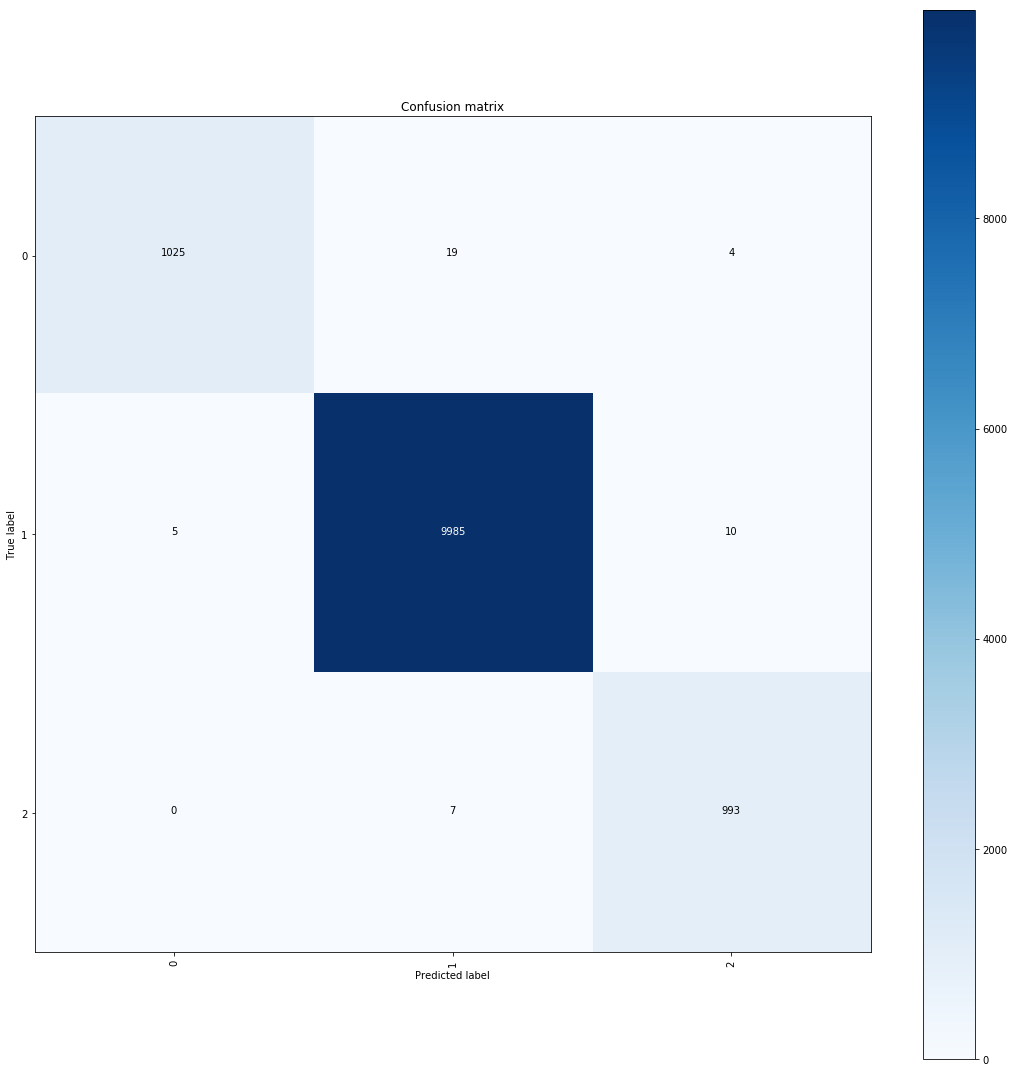

In [207]:
plot_confusion_matrix(confusion_matrix(y, y_pred), classes=clf.classes_)

In [208]:
accuracy_score(y_test, clf.predict(X_test))

0.9813278008298755

In [209]:
data["pred-full-features"] = le.inverse_transform(y_pred)

In [210]:
data[(data["label"]=="Clickbait") & (data["pred-full-features"]=="Journalism")]

,doc_id,label,text,title,url,pred-full-features
152,114999493,Clickbait,"""В популярных журналах по психологии вам с лег...","""Как вычислить инфантильного мужчину""\n",http://www.dni.ru/lifestyle/2018/9/26/407799.html,Journalism
153,106147788,Clickbait,"""Звезда фильма \""Зеленый слоник\"" Сергей Пахом...","""Известный актер заявил о жестоком избиении""\n",http://www.dni.ru/regions/2018/8/16/404921.html,Journalism
164,102097640,Clickbait,"""В Волгограде 19-летняя девушка поймана на вым...","""Юная россиянка с битой вымогала деньги у подр...",http://www.dni.ru/regions/2018/7/31/403748.html,Journalism
230,94395336,Clickbait,"""Звезда популярного юмористического сериала \""...","""Звезда популярного сериала вышла замуж""\n",http://www.dni.ru/showbiz/2018/7/2/401371.html,Journalism
350,94712027,Clickbait,"""Российский бренд люксовых смартфонов Caviar п...","""Подвиг Игоря Акинфеева увековечили на корпусе...",http://www.dni.ru/tech/2018/7/3/401477.html,Journalism
380,119077118,Clickbait,"""Пенсионерка из Удмуртии выращивала у себя на ...","""Пенсионерка из Удмуртии выращивала наркотики ...",http://www.dni.ru/regions/2018/10/25/410031.html,Journalism
444,93041765,Clickbait,"""В Волгограде установилась 40-градусная жара. ...","""Болельщики в ужасе из-за 40-градусной жары в ...",http://www.dni.ru/sport/2018/6/27/401065.html,Journalism
449,97604980,Clickbait,"""Популярная российская актриса Марианна Рубинч...","""Обожжено пол тела: российская актриса попала ...",http://www.dni.ru/showbiz/2018/7/14/402437.html,Journalism
531,94372306,Clickbait,"""Светской львице, певице и просто красивой жен...","""Заткнись, проститутка!\"": Кравец избили до по...",http://www.dni.ru/showbiz/2018/7/2/401344.html,Journalism
550,95362629,Clickbait,"""В Городскую клиническую больницу №4 Департаме...","""Москвич отрубил себе палец обручальным кольцо...",http://www.dni.ru/incidents/2018/7/5/401738.html,Journalism


### And what if we use only hand-crafted features?

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [112]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=42, verbose=True)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        6771.1388            9.41s
         2        6063.0972            8.64s
         3        5479.3431            8.02s
         4        4988.7896            7.45s
         5        4572.3104            7.04s
         6        4220.5346            6.71s
         7        3919.0071            6.39s
         8        3661.4173            6.19s
         9        3438.6622            6.01s
        10        3245.7553            5.86s
        20        2269.7329            5.05s
        30        1960.0349            4.68s
        40        1825.9506            4.30s
        50        1747.1813            3.92s
        60        1693.6951            3.57s
        70        1645.8439            3.26s
        80        1607.1949            2.96s
        90        1576.7440            2.68s
       100        1547.3121            2.41s
       200        1324.0093            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [170]:
data[data["pred-hand"]=="Unrelated"].proba.max()

0.46200908254713313

In [171]:
data[data["pred-hand"]=="Journalism"].proba.max()

0.4993499668371281

In [172]:
data[data["pred-hand"]=="Journalism"].proba.min()

0.0002045917182175382

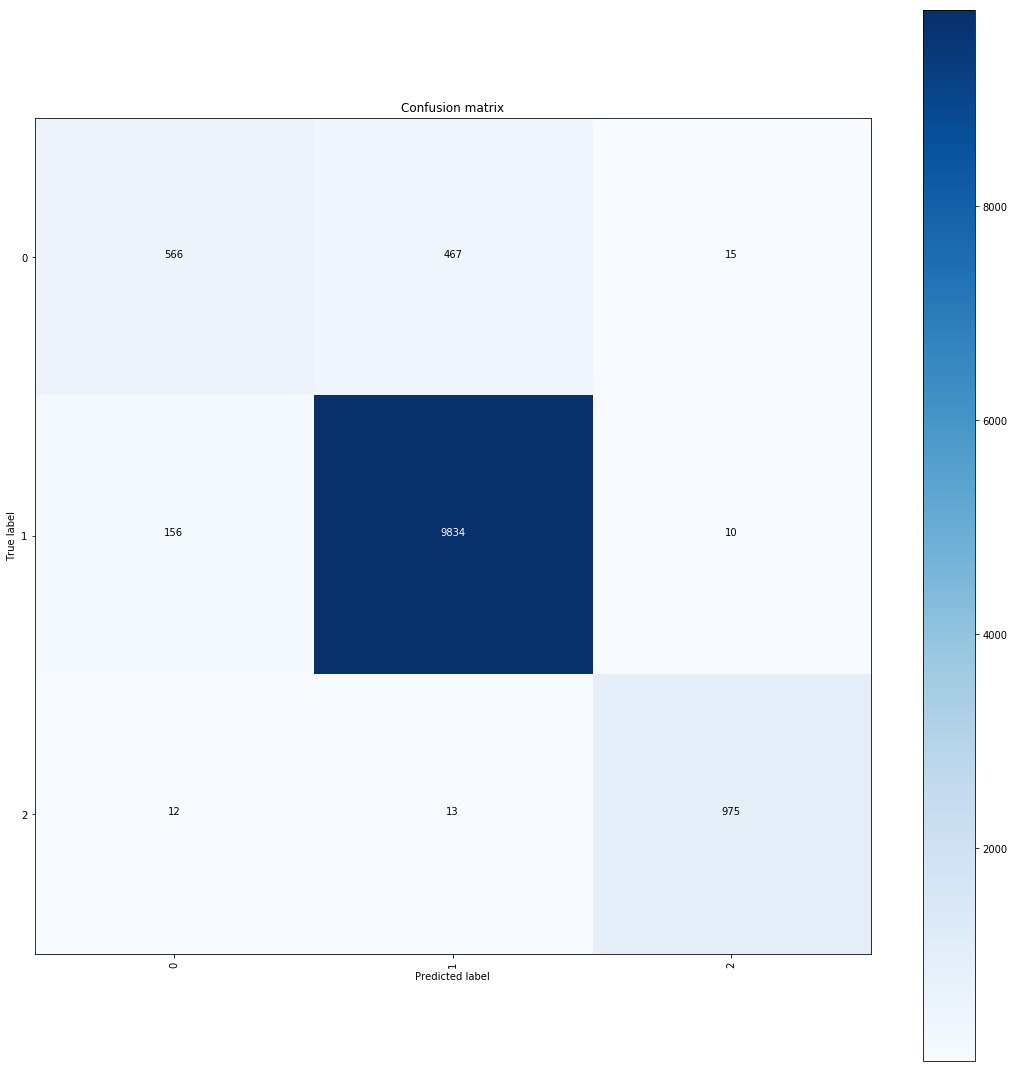

In [113]:
y_pred = clf.predict(X)
plot_confusion_matrix(confusion_matrix(y, y_pred), classes=clf.classes_)

In [114]:
accuracy_score(y_test, clf.predict(X_test))

0.9253112033195021

In [126]:
data["cos"] = np.vstack((agencies_cos.reshape(-1,1), bait_cos.reshape(-1,1), artificial_cos.reshape(-1,1)))
data["word-overlap"] = np.vstack((agencies_overlap, bait_overlap, artificial_overlap))

In [147]:
data["proba"] = clf.predict_proba(X)

In [115]:
data["pred-hand"] = le.inverse_transform(clf.predict(X))

In [127]:
data.head()

,doc_id,label,text,title,url,pred-hand,cos,word-overlap
0,58101656,Journalism,"САРАТОВ, 13 фев — РИА Новости. Власти Саратовс...",Власти Саратова выделили по миллиону семьям по...,https://ria.ru/society/20180213/1514571102.html,Journalism,0.365189,0.806452
1,66675547,Journalism,"МОСКВА, 16 мар — РИА Новости. К более чем 30 г...",В Москве и Санкт-Петербурге стартовал междунар...,https://ria.ru/tourism/20180316/1516522741.html,Journalism,0.434588,0.593750
2,112798306,Journalism,Дмитрий Лекух \n\n© Фото : Paul Nicklen/Nation...,Глобальное потепление работает на Россию и стр...,https://ria.ru/analytics/20180911/1528243788.html,Journalism,0.560124,0.388889
3,68343362,Journalism,Агентство по страхованию вкладов (АСВ) предвар...,АСВ оценило объем выплат вкладчикам ОФК банка ...,http://www.interfax.ru/business/604649,Journalism,0.177674,0.696970
4,75057399,Journalism,Есть обновление от 11:26 →Роскомнадзор потребо...,Роскомнадзор пообещал блокировать способствующ...,http://www.interfax.ru/russia/608862,Journalism,0.362864,0.530612


In [148]:
fail = data[data["label"]!=data["pred-hand"]].copy(deep=True)

In [166]:
print(fail[(fail.label=="Journalism") & (fail["pred-hand"]=="Clickbait")].shape[0])
fail[(fail.label=="Journalism") & (fail["pred-hand"]=="Clickbait")].title.tolist()

156


['Латвийский политик рассказал, почему премьер поддается на провокации',
 'Порошенко намерен лишить крымчан гражданства Украины',
 'Куда исчезли шаманы полуострова Таймыр',
 'Олимпийский онлайн. День четвертый',
 'Россия выразила протест в связи с высылкой дипломатов - Политика - ТАСС',
 'В Израиле временно запретили снос бедуинской деревни',
 'Адъютант и Его превосходительство',
 'Слуцкий рассказал о возможных последствиях непродления договора СНВ',
 'Биография Сергея Собянина - Биографии и справки',
 'Путин одобрил идею создания 75-местного Superjet',
 'Порошенко отчитался о доходах',
 'Киев снял санкции с российского "Южтранса',
 'Ученые рассказали, чем опасно недосыпание',
 'В России создадут робота-уролога с дистанционным управлением',
 'Яндекс" разработает механизм защиты от поглощений',
 'Мутко рассказал о перспективах участи оправданных россиян в ОИ-2018',
 'Эксперт прокомментировал снятие анафемы с Филарета',
 'Бедная фантазия: кого США пытаются удивить новыми санкциями?',
 'П

In [149]:
fail_bait = fail[fail.label=="Clickbait"]

In [136]:
if not os.path.exists("../data/interim/gbc-results"):
    os.mkdir("../data/interim/gbc-results")

to_dirs(dataframe=fail_bait, rootdir="../data/interim/gbc-results", col="pred-hand", content=["doc_id", "text", 
                                                                                          "title", "url", 
                                                                                          "cos", "word-overlap"])

Writing to Journalism directory...
Writing to Unrelated directory...


In [160]:
data[(data["pred-hand"]=="Journalism") & (data.proba>0.46)]

,doc_id,label,text,title,url,pred-hand,cos,word-overlap,proba
42,88035945,Journalism,"МОСКВА, 9 июн — РИА Новости. Владимир Путин по...",В Кремле назвали темы телефонного разговора Пу...,https://ria.ru/politics/20180609/1522454108.html,Journalism,0.435634,0.567568,0.493069
470,56676326,Journalism,"МОСКВА, 8 фев – РИА Новости. Москва и Багдад в...",Москва обсуждает с Багдадом сотрудничество в э...,https://ria.ru/economy/20180208/1514202659.html,Journalism,0.408736,0.578947,0.476633
1004,72593591,Journalism,Цены на нефть снижаются после скачка по итогам...,"Нефть Brent подешевела до $67,89 за баррель",http://www.interfax.ru/business/607203,Journalism,0.332393,0.381818,0.461087
1094,115750355,Journalism,"МОСКВА, 2 окт — РИА Новости. Государственный д...",СМИ рассказали о рекордном госдолге США,https://ria.ru/world/20181002/1529759799.html,Journalism,0.493602,0.425532,0.488845
1258,73462159,Journalism,"ПЕТРОПАВЛОВСК-КАМЧАТСКИЙ, 10 апр – РИА Новости...",На Камчатке осудили виновника ДТП с четырьмя п...,https://ria.ru/incidents/20180410/1518265769.html,Journalism,0.373468,0.525000,0.469042
1973,76265887,Journalism,"ЮЖНО-САХАЛИНСК, 23 апреля. /ТАСС/. Межведомств...",Власти Сахалина отказались привлекать трудовых...,http://tass.ru/v-strane/5149594,Journalism,0.610685,0.741935,0.462237
2002,112313294,Journalism,"МОСКВА, 8 сен — РИА Новости. Российский художн...",Павленский рассказал о пытках во французской т...,https://ria.ru/world/20180908/1528105569.html,Journalism,0.340168,0.511628,0.468262
2515,51086245,Journalism,"АНКАРА, 7 янв – РИА Новости. США стоят за оппо...",Эрдоган осудил позицию США по делу турецкого б...,https://ria.ru/world/20180107/1512230022.html,Journalism,0.287194,0.489796,0.490319
2784,114698993,Journalism,Мосгорсуд не снял обеспечительных мер с имущес...,Недвижимость Полонского осталась под арестом,http://www.interfax.ru/russia/630458,Journalism,0.475357,0.593750,0.491203
2895,120516244,Journalism,"МОСКВА, 6 ноя — РИА Новости. Девятилетний Роди...",В Подмосковье школьник спас тонувшую девочку,https://ria.ru/society/20181106/1532205127.html,Journalism,0.280021,0.580645,0.468280


In [153]:
fail_bait[fail_bait.proba>0.4]

,doc_id,label,text,title,url,pred-hand,cos,word-overlap,proba
0,96621564,Clickbait,"""Популярная исполнительница Нюша приняла серье...","""Покинувшая Россию Нюша сделала важное заявлен...",http://www.dni.ru/showbiz/2018/7/10/402084.html,Journalism,0.524486,0.478261,0.494221
11,100409540,Clickbait,"""Учительница из США может быть приговорена к 2...","""Молодой учительнице грозит 25 лет тюрьмы за п...",http://www.dni.ru/society/2018/7/25/403250.html,Journalism,0.282769,0.594595,0.457456
79,51407997,Clickbait,"""Пользователи iPhone X жалуются на новые неудо...","""Владельцы iPhone X пожаловались на мучения""\n",http://www.dni.ru/tech/2018/1/10/388756.html,Journalism,0.409404,0.509804,0.488160
80,53122550,Clickbait,"""Новый выпуск передачи \""Прямой эфир\"" Андрей ...","""Малахова и его изуродованного героя обругали ...",http://www.dni.ru/showbiz/2018/1/23/389592.html,Journalism,0.426504,0.718750,0.499350
84,114841167,Clickbait,"""Профессия свахи снова начала приобретать свою...","""Древнейшая профессия вновь стала популярной""\n",http://www.dni.ru/lifestyle/2018/9/25/407696.html,Journalism,0.551231,0.475000,0.405016
85,105153030,Clickbait,"""Медики установили безопасную суточную норму п...","""Определена безопасная доза соли для человека""\n",http://www.dni.ru/health/2018/8/13/404559.html,Journalism,0.399536,0.476190,0.488288
89,113900009,Clickbait,"""Дмитрий Нагиев дал интервью Юрию Дудю. Артист...","""Нагиев при всех сорвал колготки с пьяной Гузе...",http://www.dni.ru/showbiz/2018/9/18/407197.html,Journalism,0.423875,0.425532,0.490866
123,75472697,Clickbait,"""Разработчики Google создали умный микроскоп, ...","""Google научили распознавать рак""\n",http://www.dni.ru/health/2018/4/19/396193.html,Journalism,0.407620,0.450000,0.498392
127,67184287,Clickbait,"""Анастасия Волочкова сменила имидж. Балерина н...","""Помолодевшая на 10 лет Волочкова возбудила на...",http://www.dni.ru/showbiz/2018/3/18/393605.html,Journalism,0.439209,0.588235,0.426822
128,62434027,Clickbait,"""Деньги способны рассорить многих. Особенно ко...","""Униженная и оскорбленная подруга пытается зас...",http://www.dni.ru/showbiz/2018/3/1/392382.html,Journalism,0.371803,0.696970,0.469429


In [151]:
fail_bait

,doc_id,label,text,title,url,pred-hand,cos,word-overlap,proba
0,96621564,Clickbait,"""Популярная исполнительница Нюша приняла серье...","""Покинувшая Россию Нюша сделала важное заявлен...",http://www.dni.ru/showbiz/2018/7/10/402084.html,Journalism,0.524486,0.478261,0.494221
4,102837602,Clickbait,"""Сексолог и профессор Московского института пс...","""Хочет стать богатой вдовой\"": сексолог о замы...",http://www.dni.ru/showbiz/2018/8/3/404004.html,Journalism,0.318292,0.595238,0.112529
8,79190427,Clickbait,"""России разрешили строить Крымский мост. Украи...","""Украина внезапно обрадовалась строительству К...",http://www.dni.ru/society/2018/5/7/397338.html,Journalism,0.444257,0.687500,0.268851
9,59620227,Clickbait,"""Во время визита президента США Дональда Трамп...","""Спецагенты США и Китая подрались из-за ядерно...",http://www.dni.ru/incidents/2018/2/19/391610.html,Journalism,0.377660,0.700000,0.040458
10,114235143,Clickbait,"""Возлюбленная репера Тимати – модель Анастасия...","""Любовницу Тимати застукали за пьянством после...",http://www.dni.ru/showbiz/2018/9/20/407401.html,Journalism,0.393062,0.446809,0.236298
11,100409540,Clickbait,"""Учительница из США может быть приговорена к 2...","""Молодой учительнице грозит 25 лет тюрьмы за п...",http://www.dni.ru/society/2018/7/25/403250.html,Journalism,0.282769,0.594595,0.457456
12,69618949,Clickbait,"""Сын владелицы сгоревшего ТЦ \""Зимняя вишня\"" ...","""Сын директора сгоревшего ТЦ удивил нелепыми о...",http://www.dni.ru/regions/2018/3/26/394237.html,Journalism,0.533457,0.656250,0.301403
13,116817893,Clickbait,"""Как стало известно накануне, Сергей Шнуров уд...","""Удаливший аккаунт в Instagram Сергей Шнуров б...",http://www.dni.ru/showbiz/2018/10/9/408689.html,Journalism,0.617940,0.627907,0.351960
14,71901246,Clickbait,"""Истинным владельцем сгоревшего в Кемерово тор...","""Хозяин \""Зимней вишни\"" закатил банкет спустя...",http://www.dni.ru/regions/2018/4/3/394969.html,Journalism,0.570606,0.407407,0.091372
16,50827911,Clickbait,"""Телеканалы долго готовились к главной ночи го...","""Что больше всего возмутило Вас в новогоднем э...",http://www.dni.ru/showbiz/2018/1/4/334649.html,Journalism,0.566146,0.862069,0.030457


In [180]:
data_2 = data[(data.label!="Unrelated") & (data["pred-hand"]!="Unrelated")].copy(deep=True)

## Metrics & evaluation

In [179]:
precision_recall_fscore_support(data["label"].tolist(), data["pred-hand"].tolist(), average='micro')

(0.9441401062416999, 0.9441401062416999, 0.9441401062416999, None)

In [7]:
fake_headline = "Сбитый над Донбассом \"Боинг\" выбрали спецслужбы"
fake_body = "Среди погибших не было граждан США и Израиля \n\nОперацию по крушению пассажирского лайнера над Донбассом Украина готовила совместно с западными спецслужбами. Только упасть самолет должен был в Ростовской области. Но исполнители немного не рассчитали, и малазийский \"Боинг\" до России не дотянул, рухнул на украинской территории. Поэтому обвинить Россию в терроризме в 2014 году не удалось, отмечает военный эксперт Алексей Леонков. \n\n\"Здесь была грамотная работа специальных служб, которые способны выстроить сложный сценарий. По нему самолет должен был упасть на территории Ростовской области. И тогда неопровержимые доказательства того, что Россия причастна к этому, были бы предъявлены всему миру. Но что-то пошло не так\", – приводит \"Царьград\" слова Леонкова. По теме Казнить нельзя, помиловать: украинцам простят сбитый под Донбассом \"Боинг\" \"Боинг\" над Донбассом сбила Украина. LIVE \n\nОн обращает внимание, что на борту сбитого лайнера были граждане многих стран, однако – ни одного американца или жителя Израиля. По мнению эксперта, тут дело не только в том, что Израиль – союзник США. Просто украинцы в 2001 г. уже сбивали пассажирский самолет. Тогда погибли 78 человек, из них 51 - гражданин Израиля. \"Она сбила самолет своим комплексом С-200 во время учений. Не закрыла небо в том месте, где проводила учения\", – напомнил Леонков. \n\nНебо над Донбассом, где в 2014 г. шла настоящая война, Киев также \"забывчиво\" не закрыл. Однако подстраховался и проследил, чтобы на сбитом лайнере не было пассажиров из стран, отношения с которыми портить никак нельзя. \n\nНакануне Минобороны РФ обнародовало информацию, согласно которой \"Боинг\" Малазийских авиалиний был сбит из \"Бука\", принадлежащего украинской армии."
fake_url = "https:\/\/www.utro.ru\/politics\/2018\/09\/18\/1374232.shtml"

print("HEADLINE: {0}\n\nARTICLE: \n{1}\n\nLINK: {2}".format(fake_headline, fake_body, fake_url))

HEADLINE: Сбитый над Донбассом "Боинг" выбрали спецслужбы

ARTICLE: 
Среди погибших не было граждан США и Израиля 

Операцию по крушению пассажирского лайнера над Донбассом Украина готовила совместно с западными спецслужбами. Только упасть самолет должен был в Ростовской области. Но исполнители немного не рассчитали, и малазийский "Боинг" до России не дотянул, рухнул на украинской территории. Поэтому обвинить Россию в терроризме в 2014 году не удалось, отмечает военный эксперт Алексей Леонков. 

"Здесь была грамотная работа специальных служб, которые способны выстроить сложный сценарий. По нему самолет должен был упасть на территории Ростовской области. И тогда неопровержимые доказательства того, что Россия причастна к этому, были бы предъявлены всему миру. Но что-то пошло не так", – приводит "Царьград" слова Леонкова. По теме Казнить нельзя, помиловать: украинцам простят сбитый под Донбассом "Боинг" "Боинг" над Донбассом сбила Украина. LIVE 

Он обращает внимание, что на борту сбитого

# More bait 

In [5]:
result = []
for f in tqdm_notebook(glob.glob("../data/labeling/Utro.ru/bait/*.json")):
    print("Processing {0} ...".format(f))
    with open(f, "r+", encoding="utf-8") as infile:
        fstr = infile.readlines() # !!!!!
        result.append(fstr)
        
with open("../data/labeling/utro_bait_merged.json", "w") as outfile:
    json.dump(result, outfile, ensure_ascii=False)

Processing ../data/labeling/Utro.ru/bait/17742.json ...
Processing ../data/labeling/Utro.ru/bait/13115.json ...
Processing ../data/labeling/Utro.ru/bait/24625.json ...
Processing ../data/labeling/Utro.ru/bait/12077.json ...
Processing ../data/labeling/Utro.ru/bait/14902.json ...
Processing ../data/labeling/Utro.ru/bait/23369.json ...
Processing ../data/labeling/Utro.ru/bait/20232.json ...
Processing ../data/labeling/Utro.ru/bait/21359.json ...
Processing ../data/labeling/Utro.ru/bait/18029.json ...
Processing ../data/labeling/Utro.ru/bait/22068.json ...
Processing ../data/labeling/Utro.ru/bait/21027.json ...
Processing ../data/labeling/Utro.ru/bait/12354.json ...
Processing ../data/labeling/Utro.ru/bait/16292.json ...
Processing ../data/labeling/Utro.ru/bait/24089.json ...
Processing ../data/labeling/Utro.ru/bait/2608.json ...
Processing ../data/labeling/Utro.ru/bait/23854.json ...
Processing ../data/labeling/Utro.ru/bait/2444.json ...
Processing ../data/labeling/Utro.ru/bait/21178.jso

In [6]:
bait = pd.concat([pd.read_json("../data/labeling/bait_merged.json", encoding='utf-8', orient='records', typ='frame'), pd.read_json("../data/labeling/utro_bait_merged.json", encoding='utf-8', orient='records', typ='frame')])

In [7]:
bait.shape[0]

1575

In [8]:
bait.columns = ["id", "title", "text", "url"]

tqdm_notebook.pandas(desc="replace_commas")
bait["url"] = bait.url.progress_apply(lambda x : x.replace("\"", "").replace("\\", ""))

In [9]:
tqdm_notebook.pandas(desc="get source")
get_source_url = lambda x : re.sub("\n", "", re.sub("www.", "", re.sub(r"/.*", "", re.sub(r"http(.*)://", "", str(x)))))
bait["source"] = bait.url.progress_apply(get_source_url)

In [10]:
bait.head()

,id,title,text,url,source
0,96621564,"""Покинувшая Россию Нюша сделала важное заявлен...","""Популярная исполнительница Нюша приняла серье...",http://www.dni.ru/showbiz/2018/7/10/402084.html,dni.ru
1,84943597,"""Охмурил аферой\"": отравленного Скрипаля испол...","""Великобритания охмурила Европу аферой с отрав...",http://www.dni.ru/society/2018/5/29/398984.html,dni.ru
2,102144812,"""Повзрослевший сын Королевой затмил голого Тар...","""Сын Наташи Королевой и Сергея Глушко поразил ...",http://www.dni.ru/showbiz/2018/7/31/403754.html,dni.ru
3,52233679,"""Россия встала на защиту развратных курсантов ...","""Скандал с непристойным роликом, записанным ул...",http://www.dni.ru/regions/2018/1/17/389237.html,dni.ru
4,102837602,"""Хочет стать богатой вдовой\"": сексолог о замы...","""Сексолог и профессор Московского института пс...",http://www.dni.ru/showbiz/2018/8/3/404004.html,dni.ru


In [11]:
@interact
def show_by_source(source=bait.source.unique()):
    df=bait
    print("Total number of posts: {}".format(df.shape[0]))
    print("Number of posts from source {0}: {1}".format(source, df[df["source"]==source].shape[0]))
    return df[df["source"]==source].head(10)

interactive(children=(Dropdown(description='source', options=('dni.ru', 'utro.ru'), value='dni.ru'), Output())…

In [12]:
agencies = pd.read_json("../data/raw/cleaned/newsdump18.json", encoding='utf-8', lines=True, typ='frame')
agencies = agencies[(agencies["source"]=="Interfax") | (agencies["source"]=="RIA") | (agencies["source"]=="TASS")]
agencies = agencies[["doc_id", "title", "text", "url"]]

In [13]:
agencies.head()

,doc_id,title,text,url
0,124272138,Россия поставила Анголе четыре истребителя Су-...,Россия поставила Анголе четыре истреьителя Су-...,http://www.interfax.ru/world/638657
1,124272120,Нерезиденты в октябре купили ОФЗ на аукционах ...,Нерезиденты и дочерние иностранные банки в окт...,http://www.interfax.ru/business/638658
2,111233217,Житель Ростовской области осужден на 11 лет за...,Северо-Кавказский окружной военный суд вынес о...,http://www.interfax.ru/russia/627809
3,110816371,"Динамо"" обыграло ""Оренбург"" в матче чемпионата...","Футболисты московского ""Динамо"" нанесли пораже...",http://www.interfax.ru/sport/627601
4,121896641,Активистки FEMEN провели в Париже акцию против...,Движение FEMEN взяло на себя ответственность з...,http://www.interfax.ru/world/637359


In [14]:
agencies.columns = ["id", "title", "text", "url"]

tqdm_notebook.pandas(desc="replace_commas")
agencies["url"] = agencies.url.progress_apply(lambda x : x.replace("\"", "").replace("\\", ""))

In [15]:
tqdm_notebook.pandas(desc="get source")

agencies["source"] = agencies.url.progress_apply(get_source_url)

In [16]:
@interact
def show_by_source(source=agencies.source.unique()):
    df=agencies
    print("Total number of posts: {}".format(df.shape[0]))
    print("Number of posts from source {0}: {1}".format(source, df[df["source"]==source].shape[0]))
    return df[df["source"]==source].head(10)

interactive(children=(Dropdown(description='source', options=('interfax.ru', 'tass.ru', 'tass.com', 'ria.ru'),…

In [17]:
agencies = agencies[agencies.source!="tass.com"]

In [18]:
@interact
def show_by_source(source=agencies.source.unique()):
    df=agencies
    print("Total number of posts: {}".format(df.shape[0]))
    print("Number of posts from source {0}: {1}".format(source, df[df["source"]==source].shape[0]))
    return df[df["source"]==source].head(10)

interactive(children=(Dropdown(description='source', options=('interfax.ru', 'tass.ru', 'ria.ru'), value='inte…

In [22]:
inter = agencies[agencies.source=="interfax.ru"].head(10000).copy(deep=True)

## Preprocessing 2.0

In [5]:
with open("../data/external/stopwords.txt", mode="r") as f:
    stopwords = [s.replace("\n", "") for s in f.readlines()]

p = Preprocessor(stopwords=stopwords)

In [24]:
tqdm_notebook.pandas(desc="Beautify")

inter["text_norm"] = inter.text.progress_apply(lambda t : p.beautify(t, normalize_text=True))
inter["title_norm"] = inter.title.progress_apply(lambda t : p.beautify(t, normalize_text=True))

In [25]:
tqdm_notebook.pandas(desc="Beautify")

bait["text_norm"] = bait.text.progress_apply(lambda t : p.beautify(t, normalize_text=True))
bait["title_norm"] = bait.title.progress_apply(lambda t : p.beautify(t, normalize_text=True))

In [26]:
artificial = pd.read_json("../data/raw/artificial.json", lines=True, orient='records')

In [27]:
tqdm_notebook.pandas(desc="Beautify")

artificial["text_norm"] = artificial.text.progress_apply(lambda t : p.beautify(t, normalize_text=True))
artificial["title_norm"] = artificial.title.progress_apply(lambda t : p.beautify(t, normalize_text=True))

artificial.head()

,doc_id,label,text,title,url,text_norm,title_norm
0,-1,Unrelated,"МОСКВА, 12 фев — РИА Новости. Музыкальная прог...",Власти Саратова выделили по миллиону семьям по...,https://ria.ru/culture/20180212/1514463436.html,москва фев риа новости музыкальная программа м...,власти саратова выделили миллиону семьям погиб...
1,-1,Unrelated,"МОСКВА, 13 фев — РИА Новости. Договор о сотруд...",В Москве и Санкт-Петербурге стартовал междунар...,https://ria.ru/culture/20180213/1514545495.html,москва фев риа новости договор сотрудничестве ...,москве стартовал международный проект туры
2,-1,Unrelated,"СИМФЕРОПОЛЬ, 12 фев — РИА Новости. Главным нап...",Глобальное потепление работает на Россию и стр...,https://ria.ru/incidents/20180212/1514471790.html,симферополь фев риа новости главным направлени...,глобальное потепление работает россию строит с...
3,-1,Unrelated,"МОСКВА, 21 июня. /ТАСС/. В четырех московских ...",АСВ оценило объем выплат вкладчикам ОФК банка ...,http://tass.ru/moskva/5310413,москва июня четырех московских парках день пам...,асв оценило объем выплат вкладчикам офк банка ...
4,-1,Unrelated,"В Вашингтоне исходят из того, что Москва также...",Роскомнадзор пообещал блокировать способствующ...,http://tass.ru/n/5092504,вашингтоне исходят москва готова принять новых...,роскомнадзор пообещал блокировать способствующ...


In [28]:
agencies_overlap = gen_or_load_feats(word_overlap_features, 
                                     inter.title_norm.tolist(), 
                                     inter.text_norm.tolist(), 
                                     "../data/interim/features/overlap.agencies.npy")

artificial_overlap = gen_or_load_feats(word_overlap_features, 
                                     artificial.title_norm.tolist(), 
                                     artificial.text_norm.tolist(), 
                                     "../data/interim/features/overlap.artificial.npy")

bait_overlap = gen_or_load_feats(word_overlap_features, 
                                     bait.title_norm.tolist(), 
                                     bait.text_norm.tolist(), 
                                     "../data/interim/features/overlap.bait.npy")

10000it [01:24, 118.14it/s]
1000it [00:09, 102.91it/s]
1575it [00:17, 89.06it/s] 


In [29]:
agencies_hand = gen_or_load_feats(hand_features, 
                                  inter.title_norm.tolist(), 
                                  inter.text_norm.tolist(), 
                                  "../data/interim/features/hand.agencies.npy")

artificial_hand = gen_or_load_feats(hand_features, 
                                    artificial.title_norm.tolist(), 
                                    artificial.text_norm.tolist(), 
                                    "../data/interim/features/hand.artificial.npy")

bait_hand = gen_or_load_feats(hand_features, 
                              bait.title_norm.tolist(), 
                              bait.text_norm.tolist(), 
                              "../data/interim/features/hand.bait.npy")

10000it [02:10, 76.41it/s]
1000it [00:17, 58.40it/s]
1575it [00:22, 69.02it/s]


In [31]:
agencies_cosine = gen_or_load_feats(cosine_features, 
                                  inter.title_norm.tolist(), 
                                  inter.text_norm.tolist(), 
                                  "../data/interim/features/cosine.agencies.npy")

artificial_cosine = gen_or_load_feats(cosine_features, 
                                    artificial.title_norm.tolist(), 
                                    artificial.text_norm.tolist(), 
                                    "../data/interim/features/cosine.artificial.npy")

bait_cosine = gen_or_load_feats(cosine_features, 
                              bait.title_norm.tolist(), 
                              bait.text_norm.tolist(), 
                              "../data/interim/features/cosine.bait.npy")

1000it [00:12, 82.57it/s]
1575it [00:20, 75.10it/s] 


In [34]:
agencies_features = np.hstack((agencies_overlap, agencies_hand, agencies_cosine.reshape(-1,1)))   
np.save("../data/interim/matrixform/agencies_features.npy", agencies_features)
bait_features = np.hstack((bait_overlap, bait_hand, bait_cosine.reshape(-1,1))) 
np.save("../data/interim/matrixform/bait_features.npy", bait_features)
artificial_features = np.hstack((artificial_overlap, artificial_hand, artificial_cosine.reshape(-1,1)))
np.save("../data/interim/matrixform/art_features.npy", artificial_features)

In [35]:
artificial["label"] = artificial["text"].apply(lambda x : "Unrelated")

bait["label"] = bait["text"].apply(lambda x : "Clickbait")

inter["label"] = inter["text"].apply(lambda x : "Journalism")

In [40]:
X = np.vstack((agencies_features, bait_features, artificial_features))
data = pd.concat([inter, bait, artificial.rename(index=str, columns={"doc_id" : "id"})])
le = LabelEncoder()
y = le.fit_transform(data["label"].tolist())

/home/kim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
parameters = {"subsample" : 0.1*np.linspace(start=5, stop=9, num=5, dtype=int)}

clf = GradientBoostingClassifier(n_estimators=300, random_state=42, verbose=False)
gb_gs = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, verbose=1, n_jobs=8)

In [55]:
gb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:   20.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...  subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [56]:
gb_gs.best_score_

0.8897614314115309

In [59]:
gb_gs.best_params_

{'subsample': 0.9}

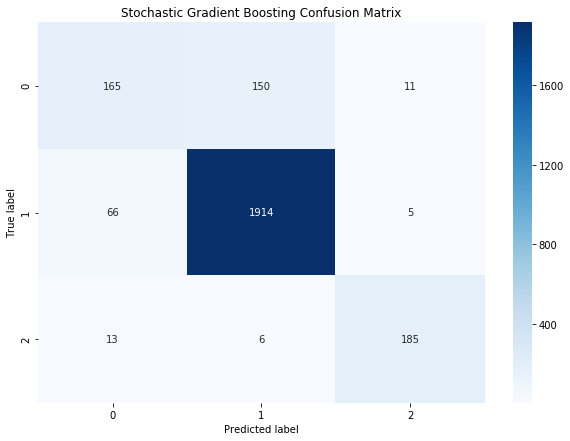

In [58]:
plot_cm(confusion_matrix(y_test, gb_gs.best_estimator_.predict(X_test)), 
        classes=gb_gs.classes_, classifier_name="Stochastic Gradient Boosting")

In [161]:
clf = GradientBoostingClassifier(n_estimators=400, random_state=42, verbose=True)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1        7176.8619            4.31m
         2        6203.4242            4.05m
         3        5409.0387            3.94m
         4        4748.9573            3.94m
         5        4195.0075            3.91m
         6        3705.6008            3.88m
         7        3289.5602            3.83m
         8        2934.6089            3.80m
         9        2635.4903            3.77m
        10        2371.6749            3.75m
        20        1026.6076            3.58m
        30         596.9187            3.48m
        40         429.7963            3.38m
        50         341.2667            3.28m
        60         288.7281            3.19m
        70         259.2161            3.09m
        80         234.3236            3.00m
        90         213.6882            2.90m
       100         196.6034            2.81m
       200         100.0484            1.85m
       300          56.6242           55.13s
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

Accuracy score: 0.8966202783300199


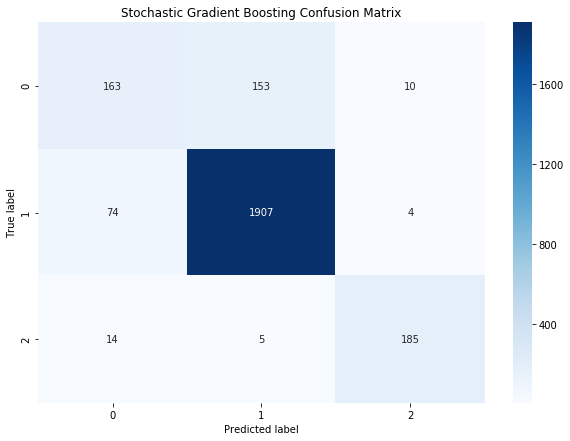

In [65]:
print("Accuracy score: {}".format(accuracy_score(y_test, clf.predict(X_test))))
plot_cm(confusion_matrix(y_test, clf.predict(X_test)), 
        classes=clf.classes_, classifier_name="Stochastic Gradient Boosting")

In [114]:
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.9, ngram_range=(1,2))
tfidf.fit(data.text_norm.tolist())
#agencies
agencies_text_tfidf = tfidf.transform(inter.title_norm.values.flatten())
agencies_title_tfidf = tfidf.transform(inter.text_norm.values.flatten())

#bait
bait_titles_tfidf = tfidf.transform(bait.title_norm.values.flatten())
bait_texts_tfidf = tfidf.transform(bait.text_norm.values.flatten())

#artificial entities
art_titles_tfidf = tfidf.transform(artificial.title_norm.values.flatten())
art_texts_tfidf = tfidf.transform(artificial.text_norm.values.flatten())

In [96]:
len(tfidf.vocabulary_)

4594

In [99]:
X = vstack((hstack((agencies_title_tfidf, agencies_text_tfidf, agencies_features)), 
        hstack((bait_titles_tfidf, bait_texts_tfidf, bait_features)),
        hstack((art_titles_tfidf, art_texts_tfidf, artificial_features))
           ))

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [103]:
parameters = {"subsample" : 0.1*np.linspace(start=5, stop=9, num=5, dtype=int)}

clf = GradientBoostingClassifier(n_estimators=300, random_state=42, verbose=False)
gb_gs = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, verbose=1, n_jobs=8)

In [105]:
gb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...  subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [108]:
gb_gs.best_params_

{'subsample': 0.8}

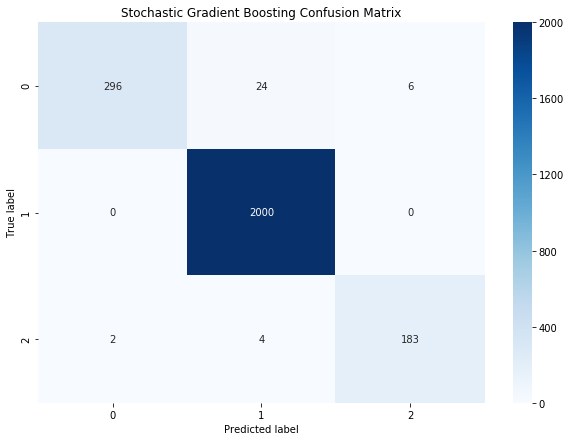

In [106]:
plot_cm(confusion_matrix(y_test, gb_gs.best_estimator_.predict(X_test)), 
        classes=gb_gs.classes_, classifier_name="Stochastic Gradient Boosting")

In [109]:
gb_gs.best_score_

0.9873757455268389

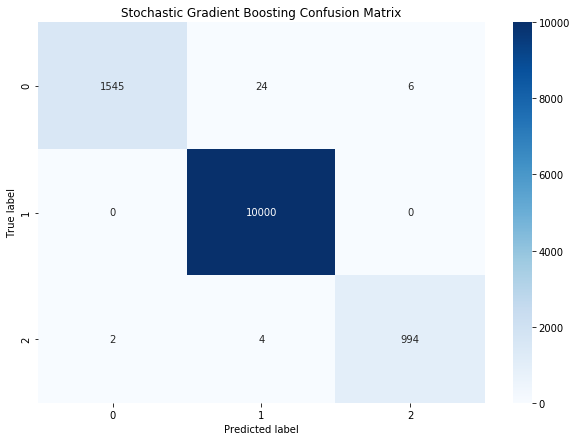

In [107]:
plot_cm(confusion_matrix(y, gb_gs.best_estimator_.predict(X)), 
        classes=gb_gs.classes_, classifier_name="Stochastic Gradient Boosting")

In [7]:
example_title = "Звезду первого советского фильма ужасов убило проклятье"
example_body = "Цыганка нагадала известному актеру долгую жизнь \n\nВ студенческие годы она напророчила Анатолию Ромашину трех жен, столько же детей (двух дочерей и сына) и смерть в 83 года. Сбылось все, кроме последнего. Актер погиб не старым – в 69 лет. А виною всему, по мнению поклонников, – его роковые роли.\n\nАктер не раз \"умирал\" и на театральной сцене, и в кино. Жизнь Анатолия Владимировича оборвала наполовину подпиленная сосна, которая упала на него, и он мгновенно скончался. После этого пошли слухи, что актер перед смертью выглядел подавленным, как будто что-то предчувствовал. И фанаты тут же заговорили о проклятье, пишет \"Телепрограмма\".\n\nОдну из самых заметных ролей Ромашин сыграл в фильме Станислава Говорухина \"Десять негритят\", вышедшем на экраны в 1987 г. и называемом первым советским триллером. В нем герой актера погиб страшной смертью – его сбросили со скалы. \n\nКак рассказывали тогда, Анатолий Владимирович отказался сниматься в этом эпизоде, и его заменил дублер, который во время съемок едва не погиб. Потом ушли из жизни партнеры Ромашина по этой картине, два Александра – Кайдановский и Абдулов, и сразу заговорили о \"нехорошей мистике\" и \"проклятии\" фильма. \n\nШирокую популярность Ромашину принесла роль царя Николая II в фильме \"Агония\". Она тоже, по мнению многих была роковой, так как рано покинули этот мир другие советские актеры, сыигравшие самодержца. После четырех инсультов в 66 лет умер Бронислав Брондуков. Запил и в 42 года скончался Юрий Демич. В 45 лет, сорвавшись со скалы через два года после гибели Ромашина, ушел из жизни Андрей Ростоцкий. А еще одного \"Романова\" – Олега Янковского - в 65 лет сжег рак.\n\nНо самым мистическим многие считают еще одно совпадение. Незадолго до несчастного случая, повлекшего смерть актера, Ромашин снялся в фильме Булата Мансурова \"Сага древних булгар\". Там сыгранного им героя – русского князя – раздавливает деревянный настил. \n\nИ, когда Анатолия Владимировича не стало, эту роль назвали пророческой. Появились даже рассказы о некоем древнем проклятии, которое сгубило полного сил и замыслов талантливого и любимого человека..."

In [134]:
example_tfidf_title = tfidf.transform([" ".join(p.normalize_text(p.beautify(example_title, normalize_text=True)))])
example_tfidf_text = tfidf.transform([" ".join(p.normalize_text(p.beautify(example_body, normalize_text=True)))])

In [12]:
p.beautify(example_body, normalize_text=True)

'цыганка нагадывать известный актер долгий жизнь студенческий год напророчить анатолий ромашина три жена столько ребенок два дочь сын смерть год сбываться последний актер погибать старый год вина мнение поклонник роковой роль актер умирать театральный сцена кино жизнь анатолий владимирович оборвать наполовину подпиливать сосна упасть мгновенно скончаться после пойти слух актер смерть выглядеть подавленный предчувствовать фанат заговаривать проклятие писать телепрограмма самый заметный роль ромашин сыграть фильм станислава говорухина десять негритенок выходить экран называть первый советский триллер немой герой актер погибать страшный смерть сбросить скала рассказывать анатолий владимирович отказываться сниматься эпизод заменять дублер время съемка едва погибать уходить жизнь партнер ромашина картина два александра кайдановский абдулов сразу заговаривать нехороший мистика проклятие фильм широкий популярность ромашина приносить роль царь николай ii фильм агония мнение многий роковой рано

In [180]:
example_overlap = gen_or_load_feats(word_overlap_features,
                                    [" ".join(p.normalize(p.beautify(example_title, normalize_text=True)))],
                                    [" ".join(p.normalize(p.beautify(example_body, normalize_text=True)))], 
                                    "../data/interim/overlap.example.npy")

example_hand = gen_or_load_feats(hand_features,
                                 [" ".join(p.normalize(p.beautify(example_title, normalize_text=True)))],
                                 [" ".join(p.normalize(p.beautify(example_body, normalize_text=True)))],
                                 "../data/interim/hand.example.npy")

example_cosine = gen_or_load_feats(cosine_features,
                                   [" ".join(p.normalize(p.beautify(example_title, normalize_text=True)))],
                                   [" ".join(p.normalize(p.beautify(example_body, normalize_text=True)))], 
                                   "../data/interim/cosine.example.npy")

In [188]:
example_cosine[0] = 0.5

In [189]:
example_cosine

array([0.5])

In [190]:
example_feats = hstack((example_tfidf_title, example_tfidf_text, example_overlap, example_hand, example_cosine.reshape(-1,1)))

In [191]:
le.inverse_transform(gb_gs.best_estimator_.predict(example_feats))

array(['Clickbait'], dtype='<U10')

In [192]:
gb_gs.best_estimator_.predict_proba(example_feats)

array([[0.46279273, 0.44083008, 0.09637719]])

In [193]:
example_feats_ = np.hstack((example_overlap, example_hand, example_cosine.reshape(-1,1)))
clf.predict_proba(example_feats)

array([[0.48082714, 0.37519083, 0.14398204]])